<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install and load packages
! pip install patool
! pip install pyunpack
! pip install captcha

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyunpack import Archive
import glob
import string
from PIL import Image
from tqdm import tqdm
import torch.nn.functional 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from captcha.image import ImageCaptcha
import string
import random


     |████████████████████████████████| 77 kB 3.9 MB/s 
     |████████████████████████████████| 101 kB 5.7 MB/s 


In [ ]:
# connect to google drive for saving models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cuda. There are 1 available gpus.
Tesla K80


# Data preprocessing

In [ ]:
# new
# download files from google drive

# load test data
!gdown --id 1-74h6oEnYm_8uCDrDNvyO2iy_LSSlLsi

! mkdir 'test'

Archive('captcha_test.tar.gz').extractall('test')

test_labels = os.listdir('test/test')
print('test files:', len(test_labels))

Downloading...
From: https://drive.google.com/uc?id=1-74h6oEnYm_8uCDrDNvyO2iy_LSSlLsi
To: /content/captcha_test.tar.gz
100% 470M/470M [00:02<00:00, 196MB/s]
test files: 50000


In [ ]:
def code_generator(size=6, chars=string.ascii_lowercase + string.digits):
    """ Generates alphanumerical code of given length """
    return ''.join(random.choice(chars) for _ in range(size))

## Create Data Loader

In [ ]:
workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 256                      # size of batch
image_size = [60, 180]                # size of imput images
nc = 3                                # number of color channels in the input images

# normalization parameters
normalize_mean = (0.485, 0.456, 0.406)
normalize_std = (0.229, 0.224, 0.225)

# for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

captcha_len = 6

In [ ]:
class Custom_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_labels):
        self.data_dir = data_dir
        self.data_labels = data_labels
        
    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, index):
        image_label = self.data_labels[index]
        image_fp = os.path.join(self.data_dir, image_label)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_label.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ])
        return transform_ops(image)

In [ ]:
# decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def UnNormalizeBatch(batch):
    for i in range(batch.shape[3]):
       batch[:,:,:,i] = (batch[:,:,:,i] * normalize_std[i]) + normalize_mean[i]

    return batch

# Creating model

In [ ]:
# these are all symbols the captchas will have
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits  
symbols_char = {k:v for k,v in enumerate(symbols, start=0)}
symbols_idx = {v:k for k,v in symbols_char.items()}
num_symbols = len(symbols_idx)

## Define model with resnet 18

In [ ]:
rnn_hidden_size = 256

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet18
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [ ]:
ctc

CTC(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

## Define loss

In [ ]:
criterion = nn.CTCLoss(blank=0)

In [ ]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [symbols_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = torch.nn.functional.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

## Train model

In [ ]:
num_epochs = 4 # number of iterations for data
n_generating = 8 # number of generating new data

lr = 0.001
weight_decay = 1e-3
clip_norm = 5

! mkdir 'train'
! mkdir 'train/train'

In [ ]:
optimizer = optim.Adam(ctc.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [ ]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [ ]:
# train with new data every couple of iteration

epoch_losses = []
iteration_losses = []
num_updates_epochs = []

# inicialize CAPTCHA with custom fonts:
fonts = ['/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/fonts/calibri.ttf',
         '/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/fonts/times.ttf',
         '/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/fonts/arial.ttf']
image = ImageCaptcha(width = 180, height = 80, fonts = fonts) 

N = 100000                      # number of generated codes

version_of_model = 1

for generation in range(n_generating):

    # delete old files and create new folder
    !rm -rf train
    ! mkdir 'train'
    ! mkdir 'train/train'

    # generate captcha codes
    for i in tqdm(range(N)):
        label = code_generator(captcha_len)
        # save in separate png files:
        image.write(label,'train/train/{}.png'.format(label))

    train_labels = os.listdir('train/train')
    dataset_train = Custom_Dataset('train/train', train_labels) 
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=workers, shuffle=True)

    help_const = 0

    for epoch in tqdm(range(1, num_epochs+1)):
        epoch_loss_list = [] 
        num_updates_epoch = 0
        for image_batch, text_batch in train_loader:
            optimizer.zero_grad()
            text_batch_logits = ctc(image_batch.to(device))
            loss = compute_loss(text_batch, text_batch_logits)
            iteration_loss = loss.item()

            if np.isnan(iteration_loss) or np.isinf(iteration_loss):
                continue
              
            num_updates_epoch += 1
            iteration_losses.append(iteration_loss)
            epoch_loss_list.append(iteration_loss)
            loss.backward()
            nn.utils.clip_grad_norm_(ctc.parameters(), clip_norm)
            optimizer.step()

            help_const = help_const + 1
            if (help_const % 100 == 0):
                print("Batch:{}    Loss:{}".format(help_const, np.mean(epoch_loss_list)))

        epoch_loss = np.mean(epoch_loss_list)
        print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
        epoch_losses.append(epoch_loss)
        num_updates_epochs.append(num_updates_epoch)
        lr_scheduler.step(epoch_loss)

        torch.save(ctc.state_dict(), "/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/model_final_6_{}.pt".format(version_of_model))
        version_of_model = version_of_model + 1

        help_const = 0


  0%|          | 0/4 [00:00<?, ?it/s]

Batch:100    Loss:3.914863018989563
Batch:200    Loss:3.361518838405609
Batch:300    Loss:3.0123445971806846


 25%|██▌       | 1/4 [04:45<14:16, 285.34s/it]

Epoch:1    Loss:2.813288248408481    NumUpdates:391
Batch:100    Loss:2.078455345630646
Batch:200    Loss:2.0526347088813783
Batch:300    Loss:2.0308249803384144


 50%|█████     | 2/4 [09:29<09:29, 284.78s/it]

Epoch:2    Loss:2.014374901571542    NumUpdates:391
Batch:100    Loss:1.9302525007724762
Batch:200    Loss:1.9176765352487564
Batch:300    Loss:1.9091581841309866


 75%|███████▌  | 3/4 [14:13<04:44, 284.46s/it]

Epoch:3    Loss:1.9034401346045686    NumUpdates:391
Batch:100    Loss:1.8765612637996674
Batch:200    Loss:1.8645080214738845
Batch:300    Loss:1.8570577577749887


100%|██████████| 4/4 [18:57<00:00, 284.38s/it]

Epoch:4    Loss:1.8531854085605164    NumUpdates:391



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:100    Loss:1.836957792043686
Batch:200    Loss:1.830547788143158
Batch:300    Loss:1.8269632271925609


 25%|██▌       | 1/4 [04:44<14:12, 284.30s/it]

Epoch:1    Loss:1.8231969843130282    NumUpdates:391
Batch:100    Loss:1.7947300732135774
Batch:200    Loss:1.7901365262269975
Batch:300    Loss:1.796667573451996


 50%|█████     | 2/4 [09:28<09:28, 284.01s/it]

Epoch:2    Loss:1.7949713852704334    NumUpdates:391
Batch:100    Loss:1.7762696146965027
Batch:200    Loss:1.7741122496128083
Batch:300    Loss:1.7811013988653819


 75%|███████▌  | 3/4 [14:11<04:43, 283.94s/it]

Epoch:3    Loss:1.780661666789628    NumUpdates:391
Batch:100    Loss:1.7649248707294465
Batch:200    Loss:1.7707149159908295
Batch:300    Loss:1.7668404416243235


100%|██████████| 4/4 [18:55<00:00, 283.94s/it]

Epoch:4    Loss:1.7641487886838596    NumUpdates:391



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:100    Loss:1.7831059503555298
Batch:200    Loss:1.7850049144029618
Batch:300    Loss:1.7791437832514445


 25%|██▌       | 1/4 [04:44<14:12, 284.07s/it]

Epoch:1    Loss:1.7795548783543775    NumUpdates:391
Batch:100    Loss:1.7602642095088958
Batch:200    Loss:1.7554199123382568
Batch:300    Loss:1.7577686762809754


 50%|█████     | 2/4 [09:27<09:27, 283.92s/it]

Epoch:2    Loss:1.7600617835588772    NumUpdates:391
Batch:100    Loss:1.7558880186080932
Batch:200    Loss:1.7513654166460038
Batch:300    Loss:1.7577133226394652


 75%|███████▌  | 3/4 [14:11<04:43, 283.85s/it]

Epoch:3    Loss:1.7561435513484203    NumUpdates:391
Batch:100    Loss:1.7484942388534546
Batch:200    Loss:1.7511364388465882
Batch:300    Loss:1.7539807069301605


100%|██████████| 4/4 [18:55<00:00, 283.77s/it]

Epoch:4    Loss:1.7574572419876333    NumUpdates:391



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:100    Loss:1.754683222770691
Batch:200    Loss:1.755817431807518
Batch:300    Loss:1.7551639493306477


 25%|██▌       | 1/4 [04:43<14:11, 283.79s/it]

Epoch:1    Loss:1.7537296403704397    NumUpdates:391
Batch:100    Loss:1.7455015289783478
Batch:200    Loss:1.7473796421289445
Batch:300    Loss:1.7435586814085642


 50%|█████     | 2/4 [09:26<09:26, 283.38s/it]

Epoch:2    Loss:1.7450575892577695    NumUpdates:391
Batch:100    Loss:1.7536261510848998
Batch:200    Loss:1.7485037904977798
Batch:300    Loss:1.7473096267382304


 75%|███████▌  | 3/4 [14:10<04:43, 283.29s/it]

Epoch:3    Loss:1.7481426582921802    NumUpdates:391
Batch:100    Loss:1.747786409854889
Batch:200    Loss:1.7516801750659943
Batch:300    Loss:1.7507714164257049


100%|██████████| 4/4 [18:53<00:00, 283.26s/it]

Epoch:4    Loss:1.7499641472726222    NumUpdates:391



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:100    Loss:1.7759754717350007
Batch:200    Loss:1.75944572865963
Batch:300    Loss:1.757177605231603
Epoch:1    Loss:1.7538049754584233    NumUpdates:391


 25%|██▌       | 1/4 [04:43<14:09, 283.09s/it]

Batch:100    Loss:1.7363244414329528
Batch:200    Loss:1.7368739742040633
Batch:300    Loss:1.7393519504865012


 50%|█████     | 2/4 [09:25<09:25, 282.56s/it]

Epoch:2    Loss:1.7412074340883728    NumUpdates:391
Batch:100    Loss:1.7362958252429963
Batch:200    Loss:1.735122110247612
Batch:300    Loss:1.740102673371633


 75%|███████▌  | 3/4 [14:07<04:42, 282.30s/it]

Epoch:3    Loss:1.7428037089764918    NumUpdates:391
Batch:100    Loss:1.7333556175231934
Batch:200    Loss:1.7306518578529357
Batch:300    Loss:1.731540752251943


100%|██████████| 4/4 [18:49<00:00, 282.31s/it]

Epoch:4    Loss:1.731970604423367    NumUpdates:391



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:100    Loss:1.7544707763195038
Batch:200    Loss:1.7539722573757173
Batch:300    Loss:1.7490795413653055
Epoch:1    Loss:1.7455798881438078    NumUpdates:391


 25%|██▌       | 1/4 [04:44<14:12, 284.17s/it]

Batch:100    Loss:1.7498919069766998
Batch:200    Loss:1.7414581829309463
Batch:300    Loss:1.7404004589716593


 50%|█████     | 2/4 [09:27<09:27, 283.77s/it]

Epoch:2    Loss:1.740082997495256    NumUpdates:391
Batch:100    Loss:1.7324585711956024
Batch:200    Loss:1.7328130078315735
Batch:300    Loss:1.734818516174952


 75%|███████▌  | 3/4 [14:10<04:43, 283.47s/it]

Epoch:3    Loss:1.735720108537113    NumUpdates:391
Batch:100    Loss:1.7298878037929535
Batch:200    Loss:1.7358347177505493
Batch:300    Loss:1.7345719500382741


100%|██████████| 4/4 [18:53<00:00, 283.45s/it]

Epoch:4    Loss:1.7323779861640443    NumUpdates:391



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:100    Loss:1.7630124807357788
Batch:200    Loss:1.7560734921693801
Batch:300    Loss:1.7516734902064006


 25%|██▌       | 1/4 [04:42<14:08, 282.82s/it]

Epoch:1    Loss:1.7494264694735826    NumUpdates:391
Batch:100    Loss:1.7430478191375733
Batch:200    Loss:1.7375239485502243
Batch:300    Loss:1.734695781469345


 50%|█████     | 2/4 [09:25<09:25, 282.68s/it]

Epoch:2    Loss:1.7342202325001397    NumUpdates:391
Epoch    26: reducing learning rate of group 0 to 1.0000e-04.
Batch:100    Loss:1.666839154958725
Batch:200    Loss:1.6517896676063537
Batch:300    Loss:1.6448669254779815


 75%|███████▌  | 3/4 [14:07<04:42, 282.59s/it]

Epoch:3    Loss:1.6409521169979553    NumUpdates:391
Batch:100    Loss:1.6200997924804688
Batch:200    Loss:1.6184112614393233
Batch:300    Loss:1.6173253333568574


100%|██████████| 4/4 [18:50<00:00, 282.67s/it]

Epoch:4    Loss:1.6173299398568586    NumUpdates:391



  8%|▊         | 8087/100000 [01:00<11:08, 137.47it/s]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## Save model

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/model_final_6.pt"
torch.save(ctc.state_dict(), PATH)

## Load model

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/model_final_6_28.pt"

ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

ctc.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Make predictions

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = torch.nn.functional.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [symbols_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
test_labels = os.listdir('test/test')
dataset_test = Custom_Dataset('test/test', test_labels) 
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=workers, shuffle=True)

results_test = pd.DataFrame(columns=['actual', 'prediction'])
# test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

100%|██████████| 196/196 [01:08<00:00,  2.86it/s]


In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,fmwxm9,fmmwxxm99,fmwxm9
1,q97ld2,q9977ldd2,q97ld2
2,9t3npk,99t3nppkk,9t3npk
3,ig0dm6,igg0ddmm6,ig0dm6
4,kzapsw,kzaapssww,kzapsw


# Evaluate model

In [ ]:
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print('Test accuracy: ', test_accuracy)

Test accuracy:  0.88112


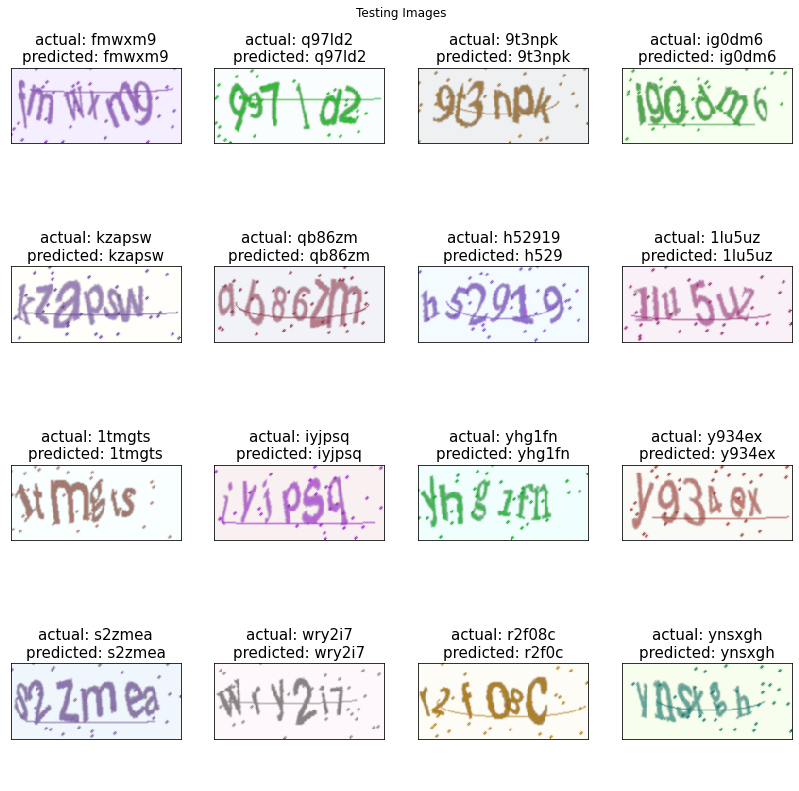

In [ ]:
# view some test images and predictions

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    result = results_test.iloc[i]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = mpimg.imread('test/test/{}.png'.format(result[0]))
    ax.imshow(img, interpolation='nearest')
    plt.title('actual: ' + result[0] + '\n' + 'predicted: ' + result[2], color='k', fontsize=15)

## Distance for compare strings similarity

In [ ]:
! pip install textdistance

from textdistance import ratcliff_obershelp

In [ ]:
for i in tqdm(range(len(results_test))):
    results_test['ratcliff_obershelp'] = ratcliff_obershelp(results_test.iloc[i,0], results_test.iloc[i,2])

100%|██████████| 50000/50000 [00:30<00:00, 1647.69it/s]


In [ ]:
print('Test Ratcliff-Obershelp: ', results_test['ratcliff_obershelp'].mean())

Test Ratcliff-Obershelp:  1.0
